In [1]:
import sys; sys.path.append('../..') ; sys.path.append('..') ; from utils import *
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *

import torch ; import torch.utils.data as data
import pytorch_lightning as pl
# dummy trainloader 
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True) 
device = torch.device('cuda:0')

import matplotlib.pyplot as plt

# Concentric Annuli Dataset
Non-augmented Neural ODE versions

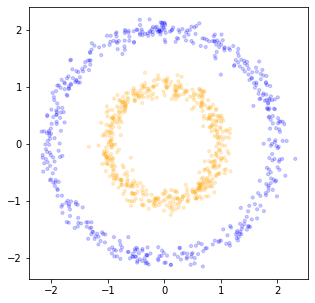

In [2]:
X, y = sample_annuli()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_scatter(ax, X, y)

In [3]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.bs = 1024
        self.iter = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iter += 1
        x0, y = sample_annuli(device=device, n_samples=self.bs)
        yh = self.model(x0)   
        loss = nn.MSELoss()(yh, y[:,None].float())
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-6)

    def train_dataloader(self):
        return trainloader

-------------------------
# Vanilla Neural ODE

In [4]:
hdim = 32
f = nn.Sequential(
        nn.Linear(2, hdim),
        nn.Tanh(),
        nn.Linear(hdim, hdim),
        nn.Tanh(),
        nn.Linear(hdim, 2))

# init to 0 the parameters of the last linear layer of the vector field
for p in f[-1].parameters(): torch.nn.init.zeros_(p)

nde = NeuralDE(f, sensitivity='adjoint', solver='dopri5', atol=1e-5, rtol=1e-5).to(device)
model = nn.Sequential(nde, nn.Linear(2, 1)).to(device)

In [5]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=2000, progress_bar_refresh_rate=1)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1 K   


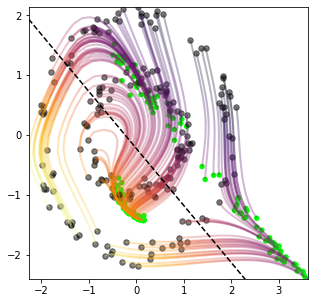

In [6]:
plot_traj(model);

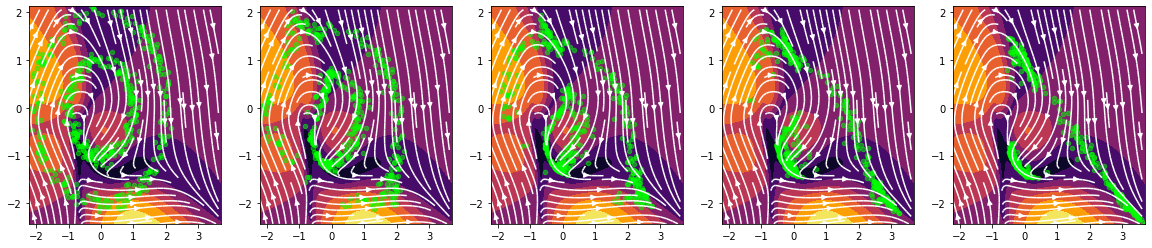

In [7]:
plot_vector_field(model);

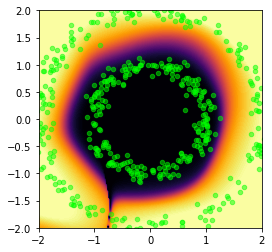

In [8]:
plot_decision_boundary(model);

______________
# Contatenated Depth (aka DepthCat) 

In [9]:
hdim = 32
f = nn.Sequential(
        DepthCat(1),
        nn.Linear(2+1, hdim),
        nn.Tanh(),
        DepthCat(1),
        nn.Linear(hdim+1, hdim),
        nn.Tanh(),
        nn.Linear(hdim, 2))

for p in f[-1].parameters(): torch.nn.init.zeros_(p)

nde = NeuralDE(f, sensitivity='adjoint', solver='dopri5', atol=1e-5, rtol=1e-5).to(device)
model = nn.Sequential(nde, nn.Linear(2, 1)).to(device)

In [10]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=2000, progress_bar_refresh_rate=1)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1 K   


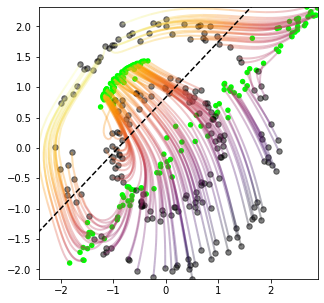

In [11]:
plot_traj(model);

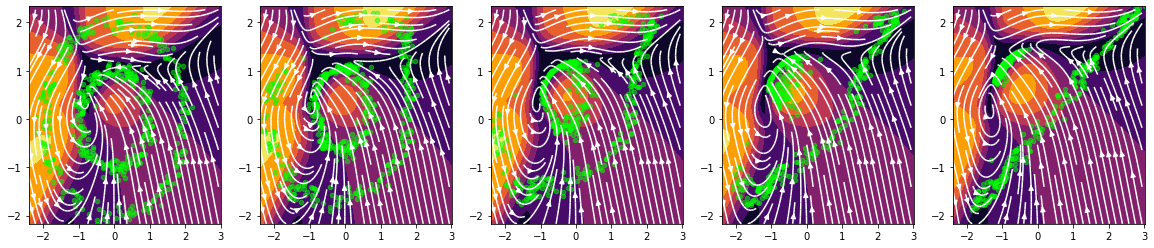

In [12]:
plot_vector_field(model);

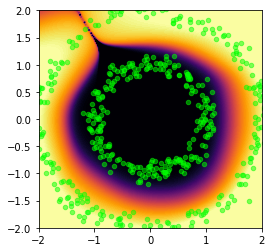

In [13]:
plot_decision_boundary(model);

_____________
# Galerkin

In [14]:
hdim = 16
f = nn.Sequential(
        nn.Linear(2, hdim),
        nn.Tanh(),
        DepthCat(1),
        GalLinear(hdim, hdim, n_harmonics=5),
        nn.Tanh(),
        nn.Linear(hdim, 2))

nde = NeuralDE(f, sensitivity='adjoint', solver='dopri5', atol=1e-5, rtol=1e-5).to(device)
model = nn.Sequential(nde, nn.Linear(2, 1)).to(device)

In [15]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=2000, progress_bar_refresh_rate=1)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2 K   


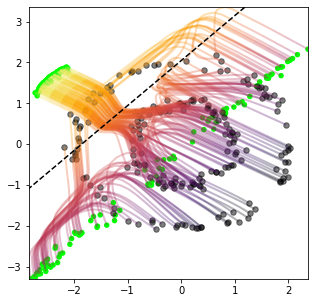

In [16]:
plot_traj(model);

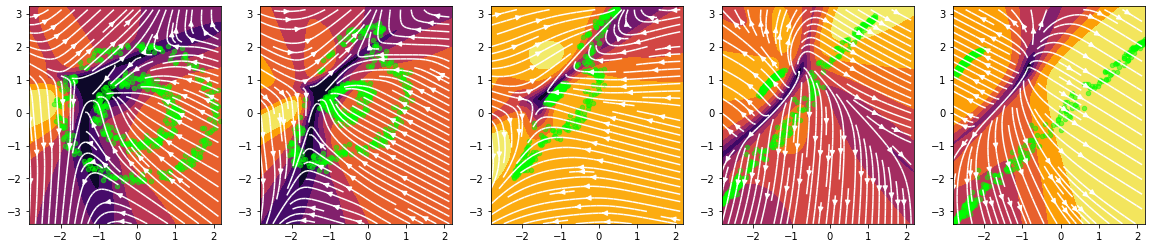

In [17]:
plot_vector_field(model);

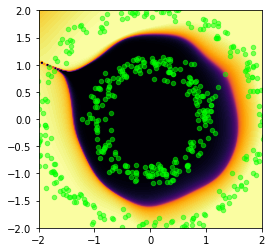

In [18]:
plot_decision_boundary(model);

----------
# Data Controlled

In [19]:
hdim = 32
f = nn.Sequential(
        DataControl(),
        nn.Linear(4, hdim),
        nn.Softplus(),
        nn.Linear(hdim, 2))

nde = NeuralDE(f, sensitivity='adjoint', solver='dopri5', atol=1e-5, rtol=1e-5).to(device)
model = nn.Sequential(nde, nn.Linear(2, 1)).to(device)

In [20]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=2000, progress_bar_refresh_rate=1)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 229   


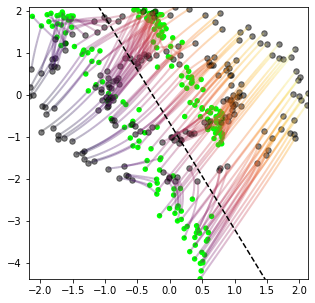

In [21]:
plot_traj(model);

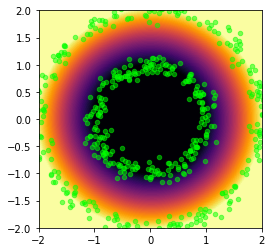

In [22]:
plot_decision_boundary(model);